<h2 align=center> Facial Expression Recognition</h2>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf

import cv2
from skimage.transform import resize

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


## Getting total number of images of each category

In [2]:
import os

for expression in os.listdir("../fer2013-kaggle/train"):
    print(str(len(os.listdir("../fer2013-kaggle/train/" + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


## Generate Training and Validation Batches

In [3]:
from tensorflow.python.lib.io import file_io

def preprocess_input(x):
    x /= 127.5
    x -= 1.
    return x

# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
    # dataset: Data path
def get_data(dataset):
    data = pd.read_csv(dataset)
    pixels = data['Paths'].tolist()
    images = np.empty((len(data), img_size, img_size, 3))
    i = 0

    for pixel_path in pixels:
        if i%5000 ==0:
            print(i," done")
        single_image = cv2.imread('../'+pixel_path, cv2.IMREAD_GRAYSCALE)
        #single_image = np.asarray(single_image).reshape(48, 48) # Dimension: 48x48
        single_image = resize(single_image, (img_size, img_size), order = 3, mode = 'constant') # Dimension: 139x139x3 (Bicubic)
        ret = np.empty((img_size, img_size, 3))  
        ret[:, :, 0] = single_image
        ret[:, :, 1] = single_image
        ret[:, :, 2] = single_image
        images[i, :, :, :] = ret
        i += 1
    
    images = preprocess_input(images)
    labels = to_categorical(data['Expression'])

    return images, labels    

In [4]:
img_size = 64

In [5]:
# Data preparation
train_data_x, train_data_y  = get_data('../fer2013-kaggle/Train.csv')
val_data  = get_data('../fer2013-kaggle/Test.csv')

0  done
5000  done
10000  done
15000  done
20000  done
25000  done
0  done
5000  done


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


datagen_validation = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = train_preprocessor.flow(
    train_data_x,
    train_data_y,
    batch_size  = batch_size)

'''validation_generator = datagen_validation.flow_from_directory(
    "fer2013-kaggle/test/",
    class_mode="categorical",
    target_size=(img_size,img_size),
    color_mode='grayscale',
    shuffle=False,
    batch_size=batch_size,
)'''

'validation_generator = datagen_validation.flow_from_directory(\n    "fer2013-kaggle/test/",\n    class_mode="categorical",\n    target_size=(img_size,img_size),\n    color_mode=\'grayscale\',\n    shuffle=False,\n    batch_size=batch_size,\n)'

## Create CNN Model

In [7]:
resnet = tf.keras.applications.ResNet50V2(weights='imagenet', 
                                        input_shape=(img_size, img_size, 3),
                                        include_top= False)

In [8]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 16, 16, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 8, 8, 512)    0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 6, 6, 256)   0           ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block1_2_pad[0][0]']     
          

                                                                                                  
 conv4_block3_out (Add)         (None, 4, 4, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 4, 4, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 4, 4, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 2, 2, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 2, 2, 1024)  0           ['conv4_block5_out[0][0]']       
          

                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 2, 2, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 2, 2, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 2, 2, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [9]:
resnet.trainable = True

for layer in resnet.layers[:-5]:
    layer.trainable = False

In [10]:
model = Sequential([
                      resnet,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])

In [11]:
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

## Training and Evaluating Model

In [12]:
epochs = 20

checkpoint = ModelCheckpoint(
                            "../Model weights/Resnet_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1
                            )

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [Early_Stopping, Reducing_LR, checkpoint]

steps_per_epoch = train_generator.n//train_generator.batch_size
#validation_steps = len//validation_generator.batch_size

In [13]:
history = model.fit(
       x = train_data_x,
    y=train_data_y,
    steps_per_epoch=len(train_data_x) // batch_size,
    epochs=epochs,
    validation_data = val_data,
    callbacks= callbacks
)

Epoch 1/20
893/897 [============================>.] - ETA: 0s - loss: 1.9129 - accuracy: 0.2794
Epoch 1: val_accuracy improved from -inf to 0.16620, saving model to Model weights\RESNET_model_2.h5
897/897 [==============================] - 29s 22ms/step - loss: 1.9120 - accuracy: 0.2796 - val_loss: 5.4682 - val_accuracy: 0.1662 - lr: 0.0010
Epoch 2/20
896/897 [============================>.] - ETA: 0s - loss: 1.7125 - accuracy: 0.3194
Epoch 2: val_accuracy did not improve from 0.16620
897/897 [==============================] - 16s 18ms/step - loss: 1.7122 - accuracy: 0.3196 - val_loss: 25.0123 - val_accuracy: 0.1193 - lr: 0.0010
Epoch 3/20
895/897 [============================>.] - ETA: 0s - loss: 1.6853 - accuracy: 0.3293
Epoch 3: val_accuracy did not improve from 0.16620
897/897 [==============================] - 17s 19ms/step - loss: 1.6851 - accuracy: 0.3292 - val_loss: 250.4305 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 4/20
265/897 [=======>......................] - ETA: 9s - loss

KeyboardInterrupt: 

In [ ]:
plot_curves(history)

## Class for loading model and weights

In [14]:
from tensorflow.keras.models import model_from_json
import numpy as np

import tensorflow as tf


class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_file):
        # load model from JSON file
        self.loaded_model = load_model(model_file)

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]
    
    def predict(self, img):
        self.preds = self.loaded_model.predict(img)
        return self.preds


## Getting frames and doing prediction

In [15]:
  
import cv2
import numpy as np

facec = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')
model_facial_Exp = FacialExpressionModel("../Model weights/RESNET_model.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            single_image = resize(single_image, (img_size, img_size), order = 3, mode = 'constant') # Dimension: 139x139x3 (Bicubic)
            ret = np.empty((img_size, img_size, 3))  
            ret[:, :, 0] = single_image
            ret[:, :, 1] = single_image
            ret[:, :, 2] = single_image
            pred = model_facial_Exp.predict_emotion(ret[np.newaxis, :, :])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

## Function for showing output video

In [16]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

## Running the code

gen(VideoCamera())

In [17]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix,classification_report

225/225 [==============================] - 2s 10ms/step


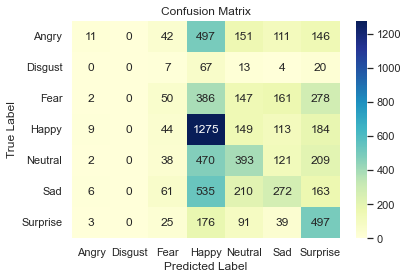

In [19]:


# Get the true labels and predicted labels for the validation set
validation_labels = np.argmax(val_data[1], axis=1)
validation_pred_probs = model.predict(val_data[0])
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]#list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(validation_labels, validation_pred_labels))

              precision    recall  f1-score   support

           0       0.33      0.01      0.02       958
           1       0.00      0.00      0.00       111
           2       0.19      0.05      0.08      1024
           3       0.37      0.72      0.49      1774
           4       0.34      0.32      0.33      1233
           5       0.33      0.22      0.26      1247
           6       0.33      0.60      0.43       831

    accuracy                           0.35      7178
   macro avg       0.27      0.27      0.23      7178
weighted avg       0.32      0.35      0.29      7178



C:\Users\prath\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prath\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prath\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
